In [1]:
# local imports
from Options import *
from Convergence import *
from HestonSensitivity import *
from Hedging import *
from VarianceReduction import *

In [2]:
# set global plotting format
plt.style.use('seaborn-v0_8-bright')
plt.style.use('seaborn-v0_8-darkgrid')

# **Part I** <br/> *Option Valuation*
---

## A. Monte Carlo Method for Black-Scholes

Write a computer program for the Monte Carlo method. Price European put option with ($T = 1$ year, $K = 99$ euro, $r = 0.06$, $S = 100$ euro, and $\sigma = 0.2$). 

In [3]:
model_params = {
    'S0': 100,
    'K': 99,
    'T': 1,
    'r': 0.06,
    'sigma': 0.2,
    'simulations': 10_000,
    'time_steps': 252
}

Estimated price of put option: 4.864182421440033


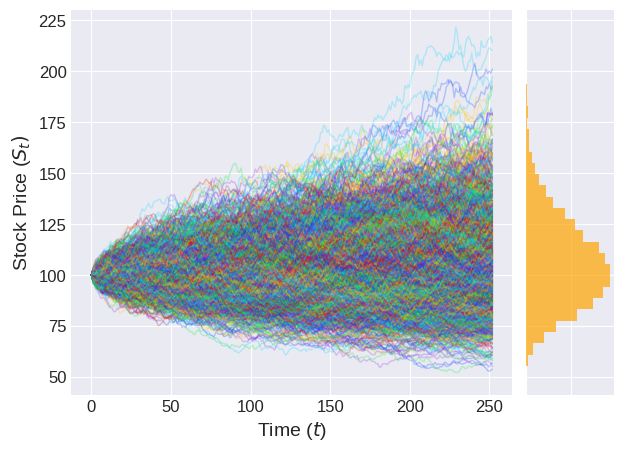

In [4]:
put = EUPut(**model_params)

price = put.price_option()
print(f"Estimated price of put option: {price}")

put.plot_stock_paths()

Carry out convergence studies by increasing the number of trials. Compare the results to the analytical solution.

In [ ]:
Convergence.analytical_solution(**model_params)

In [ ]:
Convergence.convergence_to_black_scholes()

* Varying strike price

In [ ]:
Convergence.strike_sensitivity()

* Varying sigma 

In [ ]:
Convergence.sigma_sensitivity()

* Standard error of estimate

In [ ]:
Convergence.standard_error()

### Heston model

* Pricing barrier option implemented with the Heson model and the Milstein scheme

In [ ]:
upAndOutCall = EuUpAndOutCall(
            S0=100,
            K=100,
            T=1,
            r=0.06,
            sigma=0.2,
            simulations=10_000,
            time_steps=250,
            barrier = 120, 
            theta = 0.04,
            kappa = 2, 
            epsilon = 0.1,
            rho =  -0.7,
            V0 = 0.10 
        ) 
price = upAndOutCall.price_option()
print(f"Estimated price of put option: {price}")

* Sensitivity to barrier level

In [ ]:
sensitivityAnalysis.barrier_sensitivity()

* Sensitivity to correlation ($p$)

In [ ]:
sensitivityAnalysis.correlation_sensitivity()

* Sensitivity to vol-of-vol ($\epsilon$)

In [ ]:
sensitivityAnalysis.vol_of_vol_sensitivity()

# **Part II** <br/> *Estimation of Sensitivities in MC*

---

In this second part we again consider the Black-Scholes model and estimate the hedge parameter $\delta := \frac{\partial{\pi_0}}{\partial{S_0}}$.

---

## 1. Bump-and-Revalue Method

Consider a European call with ($T = 1$ year, $K = 99$ euro, $r = 0.06$, $S = 100$ euro, and $\sigma = 0.2$). 

### *a. Choosing the bump size*

First, we conduct an experiment by varying different bump values. This allows us to see which size is necessary and sufficient for convergence to the analytical solution.

In [9]:
model_params = {
    'S0': 100,
    'K': 99,
    'T': 1,
    'r': 0.06,
    'sigma': 0.2,
    'simulations': 100_000,
    'time_steps': 252
}

In [10]:
analytical_delta = hedge_parameter_black_scholes(**model_params)

In [11]:
# estimator = Delta(option=EUCall, params=model_params)
# delta = estimator.bump_and_revalue(bump_size=0.1, same_seed=False)
# print(delta)

In [20]:
np.linspace(0.05, 1, 191)

array([0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 ,
       0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135,
       0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 ,
       0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 , 0.225,
       0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265, 0.27 ,
       0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 , 0.315,
       0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355, 0.36 ,
       0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  , 0.405,
       0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 , 0.445, 0.45 ,
       0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 , 0.495,
       0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535, 0.54 ,
       0.545, 0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 , 0.585,
       0.59 , 0.595, 0.6  , 0.605, 0.61 , 0.615, 0.62 , 0.625, 0.63 ,
       0.635, 0.64 , 0.645, 0.65 , 0.655, 0.66 , 0.665, 0.67 , 0.675,
       0.68 , 0.685,

In [21]:
bump_sizes =np.linspace(0.05, 1, 191)

estimates = []
for bump_size in bump_sizes:
    estimator = Delta(option=EUCall, params=model_params)
    delta = estimator.bump_and_revalue(bump_size)
    estimates.append(delta)

In [26]:
# export data
import pandas as pd
data = pd.DataFrame({'bump_size': bump_sizes, 'delta': estimates})
data.to_csv('data/data_q2_delta_over_bumpsize_EUCall.csv', index=False)

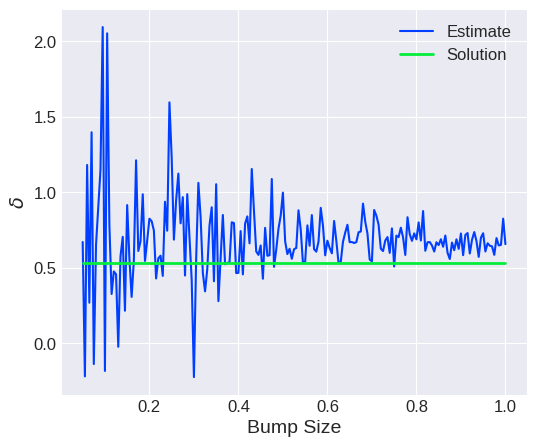

In [25]:
# plt.style.use('seaborn-v0_8-bright')
# plt.style.use('seaborn-v0_8-darkgrid')

# import pandas as pd

# bump_sizes = np.linspace(0.01, 1, 100)

# data = pd.read_csv('data/csv_q3_geometric_estimates_over_N.csv')

# estimates = data['EST']

plt.figure(figsize=(6, 5))
plt.plot(bump_sizes, estimates, linestyle='-', linewidth=1.5, label='Estimate')
plt.plot(bump_sizes, [analytical_delta]*len(bump_sizes), linestyle='-', linewidth=2, label='Solution')
plt.xlabel('Bump Size', fontsize=14)
plt.ylabel('$\\delta$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

### *b. Random vs static seed*

From the above we infer that a bump size of approximately 0.2 is best suited for our purposes. We now compare the confidence intervals obtained for two variations of the bump-and-revalue method. Namely,
- Using different seeds for the bumped and unbumped estimate of the value, &
- Using the same seed for the bumped and unbumped estimate of the value.

In [29]:
model_params = {
    'S0': 100,
    'K': 99,
    'T': 1,
    'r': 0.06,
    'sigma': 0.2,
    'simulations': 100_000,
    'time_steps': 252
}

In [30]:
random_estimates = []
for _ in range(100):
    estimator = Delta(option=EUCall, params=model_params)
    delta = estimator.bump_and_revalue(bump_size=0.5, same_seed=False)
    random_estimates.append(delta)

static_estimates = []
for _ in range(100):
    estimator = Delta(option=EUCall, params=model_params)
    delta = estimator.bump_and_revalue(bump_size=0.5, same_seed=True)
    static_estimates.append(delta)

In [31]:
# export data
import pandas as pd
data = pd.DataFrame({'random': random_estimates, 'static': static_estimates})
data.to_csv('data/data_q2_delta_random_vs_static_EUCall.csv', index=False)

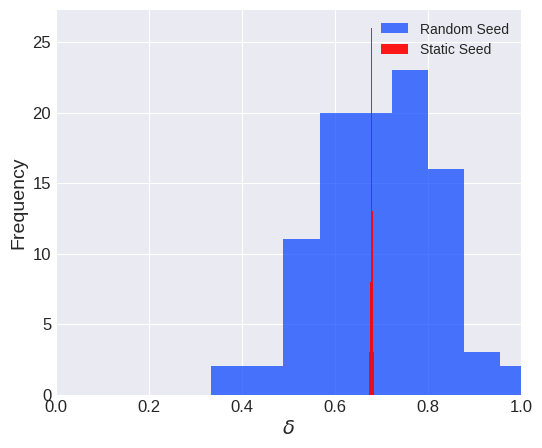

In [41]:
# plt.style.use('seaborn-v0_8-bright')
# plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(6, 5))
plt.hist(random_estimates, bins=10, alpha=0.7, label='Random Seed')
plt.hist(static_estimates, bins=10, alpha=0.9, color='red', label='Static Seed')
plt.xlabel('$\\delta$', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim(0, 1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.show()

In [9]:
mu_random, std_random = np.mean(random_estimates), np.std(random_estimates)
mu_static, std_static = np.mean(static_estimates), np.std(static_estimates)
n = len(random_estimates)

z = 1.96  # 95% CI
random_ci = z * (std_random / np.sqrt(n))
static_ci = z * (std_static / np.sqrt(n))

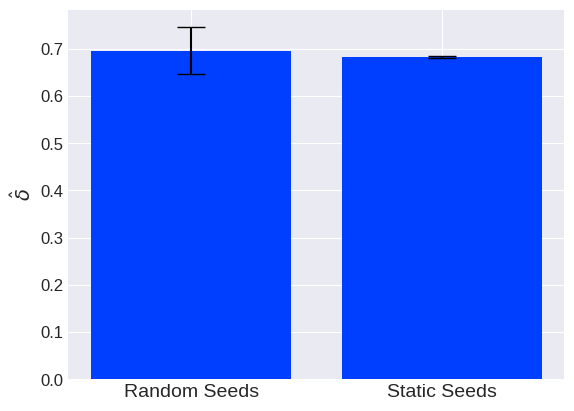

In [10]:
# plot of average delta with confidence intervals
plt.style.use('seaborn-v0_8-bright')
plt.style.use('seaborn-v0_8-darkgrid')

fig, ax = plt.subplots()

methods = ['Random Seeds', 'Static Seeds']
means = [mu_random, mu_static]
CIs = [random_ci, static_ci]

ax.bar(methods, means, yerr=CIs, capsize=10)
ax.set_ylabel('$\\hat{\\delta}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

plt.show()

## 2. Pathwise & Likelihood Ratio Methods

Consider a digital option (i.e. $\pi_0 = 1$ if $S_T > K$ at expiry or $\pi_0 = 0$ otherwise). Calculate the hedge parameter $\delta$ using the method used in question 1. 

In [3]:
# Bump-and-Revalue for Digital Option Delta
model_params = {
    'S0': 100,
    'K': 99,
    'T': 1,
    'r': 0.06,
    'sigma': 0.2,
    'simulations': 100_000,
    'time_steps': 252
}

estimator = Delta(option=DigitalOption, params=model_params)

delta = estimator.bump_and_revalue(bump_size=0.5, same_seed=True)

print(f"Estimated delta of digital option: {delta}")

Estimated delta of digital option: 0.018402078986236026


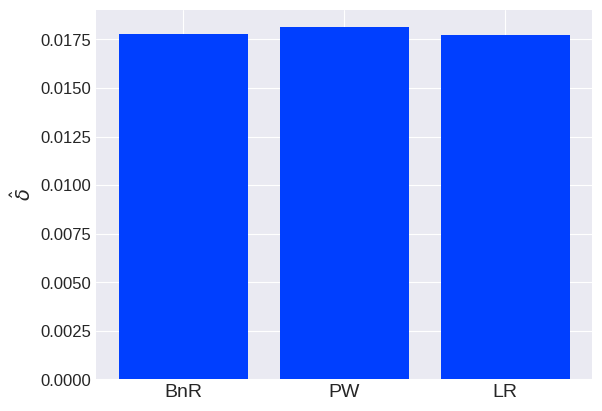

In [7]:
# compare three methods for delta estimation
model_params = {
    'S0': 100,
    'K': 99,
    'T': 1,
    'r': 0.06,
    'sigma': 0.2,
    'simulations': 100_000,
    'time_steps': 252
}
estimator = Delta(option=DigitalOption, params=model_params)
delta_BnR = estimator.bump_and_revalue(bump_size=0.5, same_seed=True)
delta_PW = estimator.path_wise()
delta_LR = estimator.likelihood_ratio()

fig, ax = plt.subplots()

methods = ['BnR', 'PW', 'LR']
deltas = [delta_BnR, delta_LR, delta_PW]
# CIs = [random_ci, static_ci]

ax.bar(methods, deltas, capsize=10)
ax.set_ylabel('$\\hat{\\delta}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

plt.show()

In [12]:
# comparison between likelihood ratio with and without smooth function
model_params = {
    'S0': 100,
    'K': 99,
    'T': 1,
    'r': 0.06,
    'sigma': 0.2,
    'simulations': 100_000,
    'time_steps': 252
}
estimator = Delta(option=DigitalOption, params=model_params)
delta_LR = estimator.likelihood_ratio()
delta_LR_smooth = estimator.likelihood_ratio_smooth()


In [13]:
delta_LR, delta_LR_smooth

(0.01822311444287629, 0.01831119326258808)

Explain your results and use the sophisticated methods discussed in the lectures, i.e.
the pathwise and likelihood ratio methods with the application of smoothing if necessary,
to improve your results.

In [14]:
model_params = {
    'S0': 100,
    'K': 99,
    'T': 1,
    'r': 0.06,
    'sigma': 0.2,
    'simulations': 100_000,
    'time_steps': 252
}

deltas_BnR, deltas_PW, deltas_LR, deltas_LR_smooth = [], [], [], []

for _ in range(100):
    estimator = Delta(option=DigitalOption, params=model_params)
    delta_BnR = estimator.bump_and_revalue(bump_size=0.5, same_seed=True)
    deltas_BnR.append(delta_BnR)

for _ in range(100):
    estimator = Delta(option=DigitalOption, params=model_params)
    delta_PW = estimator.path_wise()
    deltas_PW.append(delta_PW)

for _ in range(100):
    estimator = Delta(option=DigitalOption, params=model_params)
    delta_LR = estimator.likelihood_ratio()
    deltas_LR.append(delta_LR)

for _ in range(100):
    estimator = Delta(option=DigitalOption, params=model_params)
    delta_LR_smooth = estimator.likelihood_ratio_smooth()
    deltas_LR_smooth.append(delta_LR_smooth)

In [15]:
# export data
import pandas as pd
data = pd.DataFrame({
    'BnR': deltas_BnR,
    'PW': deltas_PW,
    'LR': deltas_LR,
    'LR_smooth': deltas_LR_smooth
})
data.to_csv('data/data_q2_delta_comparison_digital_option.csv', index=False)

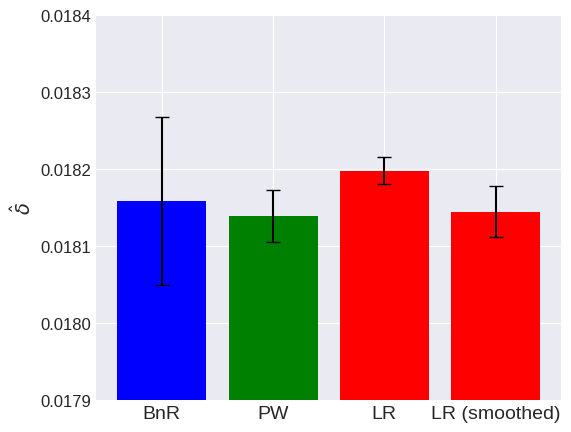

In [32]:
fig, ax = plt.subplots(figsize=(6, 5))

methods = ['BnR', 'PW', 'LR', 'LR (smoothed)']
means = [np.mean(deltas_BnR), np.mean(deltas_PW), np.mean(deltas_LR), np.mean(deltas_LR_smooth)]
CIs = [1.96 * (np.std(deltas_BnR) / np.sqrt(100)), 1.96 * (np.std(deltas_PW) / np.sqrt(100)), 1.96 * (np.std(deltas_LR) / np.sqrt(100)), 1.96 * (np.std(deltas_LR_smooth) / np.sqrt(100))]
colors = ['blue', 'green', 'red', 'red']

ax.bar(methods, means, yerr=CIs, capsize=5, color=colors)
ax.set_ylabel('$\\hat{\\delta}$', fontsize=14)
plt.ylim(0.0179, 0.0184)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

plt.show()

# **Part III** <br/> *Variance Reduction*

---

**Variance Reduction by Control Variates.** For the control variates technique an accurate estimate of the value of an option that is similar to the one that you would like to price is required. For valuation of an Asian option based on arithmetic averages one can use the value of an Asian option based on geometric averages, which is analytically solved. 

---

## **1.** Pricing Asian Options
Write a program that prices an Asian option based on geometric averages using an analytical expression.

In [4]:
model_params = {
    'S0': 100,
    'K': 99,
    'T': 1,
    'r': 0.06,
    'sigma': 0.2,
    'time_steps': 252
}

In [7]:
option = AsianOption(**model_params)
option.price_option(method='analytical')

6.474847237106069

Compare the values you obtain with the analytical expression to those obtained by using Monte-Carlo simulations.

In [8]:
pi, pi_SE = option.price_option(method='geometric')
print(f"{pi} +/- {pi_SE}")

6.29240539980554 +/- 0.2835158339924861                                                             


In [ ]:
pis, pis_SEs = [], []

Ns = np.linspace(10_000, 1_000_000, 100)
Ns = np.array(Ns, dtype=int)

for N in Ns:
    option = AsianOption(simulations=N, **model_params)
    pi, pi_SE = option.price_option(method='geometric')
    pis.append(pi)
    pis_SEs.append(pi_SE)

In [ ]:
import pandas as pd
df = pd.DataFrame({'N': Ns, 'EST': pis, 'SE': pis_SEs})
df.to_csv('csv_q3_ge_convergence.csv', index=False)

In [ ]:
# plt.style.use('seaborn-v0_8-bright')
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure(figsize=(6, 5))
plt.plot(Ns, pis, linestyle='-', linewidth=1.5, label='$estimate$')
plt.plot(Ns, [pi]*len(Ns), linestyle='-', linewidth=2, label='$solution$')
plt.fill_between(Ns, pis - 1.96*np.array(pis_SEs), pis + 1.96*np.array(pis_SEs), alpha=0.4)
plt.xlabel('$N$', fontsize=14)
plt.ylabel('$Price$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.show()


## **2.** Control Variates: Theory

Explain how control variates can reduce the variance in MC estimates.

## **3.** Control Variates: Implementation

Apply the control variates technique for the calculation of the value of the Asian option based on arithmetic averages.

In [5]:
option = AsianOption(simulations=100_000, **model_params)

option.control_variate_pricing()

6.7128565596603105

Study the performance of this technique for different parameter settings (number of paths, strike, number of time points used in the average etc.)

In [33]:
model_params = {
    'S0': 100,
    'K': 99,
    'T': 1,
    'r': 0.06,
    'sigma': 0.2,
    'time_steps': 252
}

In [36]:
pis_ari, pis_geo, pis_geo_anal, pis_cv = [], [], [], []
pis_ari_SEs, pis_geo_SEs, pis_cv_SEs = [], [], []

Ns = np.linspace(10_000, 1_000_000, 100)
Ns = np.array(Ns, dtype=int)

for N in Ns:
    option = AsianOption(simulations=N, **model_params)
    pi_ari, pi_ari_SE = option.price_option(method='arithmetic')
    pis_ari.append(pi_ari)
    pis_ari_SEs.append(pi_ari_SE)
    
for N in Ns:
    option = AsianOption(simulations=N, **model_params)
    pi_geo, pi_geo_SE = option.price_option(method='geometric', N=10)
    pis_geo.append(pi_geo)
    pis_geo_SEs.append(pi_geo_SE)
    
for N in Ns:
    option = AsianOption(simulations=N, **model_params)
    pi_cv, pi_cv_SE = option.price_option(method='control_variate', N=10)
    pis_cv.append(pi_cv)
    pis_cv_SEs.append(pi_cv_SE)

for N in Ns:
    option = AsianOption(simulations=N, **model_params)
    pi_geo_anal = option.price_option(method='analytical')
    pis_geo_anal.append(pi_geo_anal)


In [70]:
pis_ari, pis_geo, pis_geo_anal, pis_cv = [], [], [], []
pis_ari_SEs, pis_geo_SEs, pis_cv_SEs = [], [], []

Ns = np.linspace(10_000, 1_000_000, 100)
Ns = np.array(Ns, dtype=int)

for N in Ns:
    option = AsianOption(simulations=N, **model_params)
    pi_cv, pi_cv_SE = option.price_option(method='control_variate', N=26)
    pis_cv.append(pi_cv)
    pis_cv_SEs.append(pi_cv_SE)

KeyboardInterrupt: 

In [69]:
pis_cv

[-2.4410013171858536,
 -2.593675465201963,
 -2.5281009511774757,
 -2.507659831346676,
 -2.49186023092747,
 -2.572735592650665,
 -2.558338133400028,
 -2.5897159984179527,
 -2.566837902462175,
 -2.587131419805931,
 -2.5779244158514483,
 -2.570858459412988,
 -2.5946711707481507,
 -2.5700477336545475,
 -2.592939509043091,
 -2.5635025082473932,
 -2.554714575557122,
 -2.5332484020466186,
 -2.5733320315640706,
 -2.5491008227454,
 -2.5746239218839877,
 -2.568175081371073,
 -2.572558007135446,
 -2.54663595882991,
 -2.5506425865085935,
 -2.573535487917342,
 -2.5661182851886917,
 -2.5552910658009242,
 -2.5608592452004713,
 -2.5668543463092846,
 -2.581409155850249,
 -2.5618696758817197,
 -2.5765693564631085,
 -2.5495396529523178,
 -2.563101996854774,
 -2.549660019450815,
 -2.550974511623667,
 -2.5472492856800977,
 -2.5568170267567822,
 -2.568531869442411,
 -2.549854069815299,
 -2.557816827614282,
 -2.5468829052548547,
 -2.559766151534574,
 -2.555329643954321,
 -2.546625972036269,
 -2.5492907602037

In [37]:
import pandas as pd
df = pd.DataFrame({
    'N': Ns, 
    'EST_ari': pis_ari, 
    'SE_ari': pis_ari_SEs, 
    'EST_geo': pis_geo, 
    'SE_geo': pis_geo_SEs, 
    'EST_cv': pis_cv, 
    'SE_cv': pis_cv_SEs, 
    'EST_geo_anal': pis_geo_anal
})

df.to_csv('csv_q3_all_estimates.csv', index=False)

In [38]:
# import csv
data = pd.read_csv('csv_q3_all_estimates.csv')

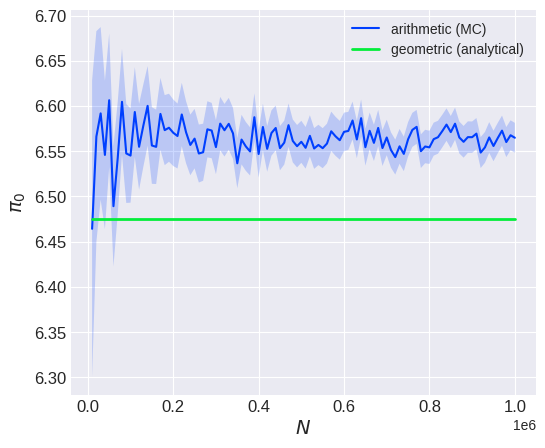

In [40]:
plt.figure(figsize=(6, 5))

plt.plot(data['N'], data['EST_ari'], linestyle='-', linewidth=1.5, label='arithmetic (MC)')
plt.plot(data['N'], data['EST_geo_anal'], linestyle='-', linewidth=2, label='geometric (analytical)')

plt.fill_between(data['N'], data['EST_ari'] - 1.96*np.array(data['SE_ari']), data['EST_ari'] + 1.96*np.array(data['SE_ari']), alpha=0.2)

plt.xlabel('$N$', fontsize=14)
plt.ylabel('$\\pi_0$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.show()


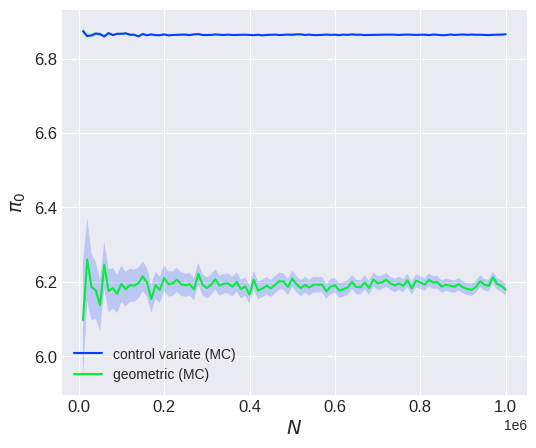

In [66]:

plt.figure(figsize=(6, 5))

plt.plot(data['N'], data['EST_cv'], linestyle='-', linewidth=1.5, label='control variate (MC)')
plt.plot(data['N'], data['EST_geo'], linestyle='-', linewidth=1.5, label='geometric (MC)')
plt.fill_between(data['N'], data['EST_geo'] - 1.96*np.array(data['SE_geo']), data['EST_geo'] + 1.96*np.array(data['SE_geo']), alpha=0.2)
plt.fill_between(data['N'], data['EST_cv'] - 1.96*np.array(data['SE_cv']), data['EST_cv'] + 1.96*np.array(data['SE_cv']), alpha=0.2)

plt.xlabel('$N$', fontsize=14)
plt.ylabel('$\\pi_0$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.show()


In [48]:
np.mean(data['EST_geo']) - np.mean(data['EST_geo_anal'])

-0.28401573478639985

In [58]:
# original code used for the calculation of beta etc

cov = np.cov(data['EST_ari'], data['EST_geo'])
beta = -cov[0, 1] / cov[1, 1]

# print(beta)

pi_cv = data['EST_ari'] - beta * (np.mean(data['EST_geo']) - np.mean(data['EST_geo_anal']))



In [59]:
pi_cv

0     6.430588
1     6.532578
2     6.558158
3     6.512255
4     6.572723
        ...   
95    6.530886
96    6.539084
97    6.526471
98    6.534004
99    6.531229
Name: EST_ari, Length: 100, dtype: float64

In [61]:
np.mean(data['EST_geo'])

6.190831502319667

In [71]:
np.mean(data['EST_geo_anal'])

6.474847237106067

In [72]:
np.mean(data['EST_ari'])

6.563739852010745

In [73]:
np.mean(data['EST_cv'])

6.864354694273379

In [ ]:

plt.figure(figsize=(6, 5))

plt.plot(data['N'], data['EST_cv'], linestyle='-', linewidth=1.5, label='control variate (MC)')
plt.plot(data['N'], data['EST_geo'], linestyle='-', linewidth=1.5, label='geometric (MC)')
plt.fill_between(data['N'], data['EST_geo'] - 1.96*np.array(data['SE_geo']), data['EST_geo'] + 1.96*np.array(data['SE_geo']), alpha=0.2)
plt.fill_between(data['N'], data['EST_cv'] - 1.96*np.array(data['SE_cv']), data['EST_cv'] + 1.96*np.array(data['SE_cv']), alpha=0.2)

plt.xlabel('$N$', fontsize=14)
plt.ylabel('$\\pi_0$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.show()
